# Stock Prediction App Function Tests

This notebook tests the main functions from `app.py` for stock prediction using Reddit sentiment and LSTM. Each section demonstrates and validates a key part of the pipeline.

## 1. Import Required Libraries and Load Environment Variables
Import all necessary libraries and load environment variables using dotenv.

In [1]:
import yfinance as yf
import praw
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv(dotenv_path='.env.local')

C:\Users\zihan\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\zihan\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\zihan\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Us

True

## 2. Test Reddit API Setup
Instantiate the Reddit API client using praw and verify credentials by fetching subreddit information.

In [3]:
reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent="REDDIT_USER_AGENT"
)

# Test: Fetch subreddit info
test_subreddit = reddit.subreddit("stocks")
print(f"Subreddit title: {test_subreddit.title}")
print(f"Subreddit description: {test_subreddit.public_description[:100]}...")

Subreddit title: Stocks - Investing and trading for all
Subreddit description: The most serious place on Reddit for Stock related discussions!  Don't hesitate to tell us about a t...


## 3. Test FinBERT Sentiment Analysis
Load the FinBERT model and tokenizer, then test the analyze_sentiment function on example sentences.

In [4]:
finbert_model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
finbert_tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

def analyze_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "neutral"
    inputs = finbert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = finbert_model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    labels = ["positive", "neutral", "negative"]
    return labels[probs.argmax().item()]

# Test on example sentences
examples = [
    "NVDA stock is going to the moon!",
    "I think the market will be flat tomorrow.",
    "Earnings were disappointing and I sold all my shares."
]
for text in examples:
    print(f"Text: {text}\nSentiment: {analyze_sentiment(text)}\n")

Text: NVDA stock is going to the moon!
Sentiment: positive

Text: I think the market will be flat tomorrow.
Sentiment: positive

Text: Earnings were disappointing and I sold all my shares.
Sentiment: negative



## 4. Test Fetching Reddit Comments
Call fetch_reddit_comments with a sample stock ticker and display the resulting DataFrame.

In [5]:
def fetch_reddit_comments(stock_ticker, limit=100):
    query = f'(title:"{stock_ticker}" OR selftext:"{stock_ticker}") AND (title:stock OR title:share OR title:earnings OR title:market)'
    finance_keywords = [
        "stock", "share", "ticker", "dividend", "price", "earnings",
        "revenue", "guidance", "options", "puts", "calls", "market",
        "invest", "investing", "hold", "buy", "sell", "portfolio"
    ]
    subreddit = reddit.subreddit("all")
    records = []
    def is_finance_related(text, keywords):
        text_lower = text.lower()
        return any(word in text_lower for word in keywords)
    for submission in subreddit.search(query, sort="relevance", time_filter="month", limit=limit):
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
            clean_body = comment.body.replace("\n", " ").strip()
            if (
                is_finance_related(clean_body, finance_keywords) and
                len(clean_body.split()) > 5 and
                comment.author not in ["AutoModerator", None]
            ):
                records.append({
                    "Post Title": submission.title,
                    "Post ID": submission.id,
                    "Comment ID": comment.id,
                    "Comment": clean_body,
                    "Score": comment.score,
                    "Author": str(comment.author),
                    "Created UTC": pd.to_datetime(comment.created_utc, unit='s')
                })
    df_comments = pd.DataFrame(records)
    if not df_comments.empty:
        df_comments.dropna(subset=["Comment"], inplace=True)
        df_comments["Sentiment"] = df_comments["Comment"].apply(lambda x: analyze_sentiment(x))
        df_comments["date"] = df_comments["Created UTC"].dt.date
    return df_comments

# Test for NVDA
df_comments = fetch_reddit_comments("NVDA", limit=50)
display(df_comments.head())

KeyboardInterrupt: 

## 5. Test Fetching Stock Data
Call fetch_stock_data with a sample stock ticker and display the resulting DataFrame.

In [2]:
def fetch_stock_data(stock_ticker, period="5y"):
    df = yf.download(stock_ticker, period=period, timeout=30)
    df = df[["Close", "Volume"]]
    df["Return"] = df["Close"].pct_change()
    df_reset = df.reset_index()
    df_reset = df_reset.rename(columns={'Date': 'date'})
    return df_reset

# Test for NVDA
df_stock = fetch_stock_data("NVDA", period="1y")
display(df_stock.head())

C:\Users\zihan\AppData\Local\Temp\ipykernel_28736\1151101705.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_ticker, period=period, timeout=30)
[*********************100%***********************]  1 of 1 completed


Price,date,Close,Volume,Return
Ticker,,NVDA,NVDA,
0,2024-08-30,119.332306,333751600,NaN
1,2024-09-03,107.965889,477155100,-0.095250
2,2024-09-04,106.176453,372470300,-0.016574
3,2024-09-05,107.176140,306850700,0.009415
4,2024-09-06,102.797523,413638100,-0.040854


## 6. Test Data Preparation and Merging
Call prepare_merged with a sample stock ticker and display the merged DataFrame with sentiment columns.

In [10]:
stock_df = fetch_stock_data("NVDA")
comments_df = fetch_reddit_comments("NVDA", limit=10)

C:\Users\zihan\AppData\Local\Temp\ipykernel_33456\1151101705.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_ticker, period=period, timeout=30)
[*********************100%***********************]  1 of 1 completed



In [67]:
def fetch_stock_data(stock_ticker, period="5y"):
    df = yf.download(stock_ticker, period=period, timeout=30)
    df = df[["Close", "Volume"]]
    df["Return"] = df["Close"].pct_change()
    df_reset = df.reset_index()
    df_reset = df_reset.rename(columns={'Date': 'date'})
    return df_reset

def fetch_reddit_comments(stock_ticker, limit=10000):
    query = f'(title:"{stock_ticker}" OR selftext:"{stock_ticker}") AND (title:stock OR title:share OR title:earnings OR title:market)'
    finance_keywords = [
        "stock", "share", "ticker", "dividend", "price", "earnings",
        "revenue", "guidance", "options", "puts", "calls", "market",
        "invest", "investing", "hold", "buy", "sell", "portfolio"
    ]
    subreddit = reddit.subreddit("all")
    records = []
    def is_finance_related(text, keywords):
        text_lower = text.lower()
        return any(word in text_lower for word in keywords)
    for submission in subreddit.search(query, sort="relevance", time_filter="year", limit=limit):
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
            clean_body = comment.body.replace("\n", " ").strip()
            if (
                is_finance_related(clean_body, finance_keywords) and
                len(clean_body.split()) > 5 and
                comment.author not in ["AutoModerator", None]
            ):
                records.append({
                    "Post Title": submission.title,
                    "Post ID": submission.id,
                    "Comment ID": comment.id,
                    "Comment": clean_body,
                    "Score": comment.score,
                    "Author": str(comment.author),
                    "Created UTC": pd.to_datetime(comment.created_utc, unit='s')
                })
    df_comments = pd.DataFrame(records)
    if not df_comments.empty:
        df_comments.dropna(subset=["Comment"], inplace=True)
        df_comments["Sentiment"] = df_comments["Comment"].apply(lambda x: analyze_sentiment(x))
        df_comments["date"] = df_comments["Created UTC"].dt.date
    return df_comments

stock_ticker = "NVDA"
stock_df = fetch_stock_data(stock_ticker)
comments_df = fetch_reddit_comments(stock_ticker, limit=50)
stock_df.columns = stock_df.columns.get_level_values(-2)
sentiment = comments_df.groupby("date")["Sentiment"].value_counts().unstack()
for col in ["positive", "neutral", "negative"]:
    if col not in sentiment:
        sentiment[col] = 0
sentiment = sentiment[["positive", "neutral", "negative"]].div(sentiment.sum(axis=1), axis=0)
sentiment = sentiment.reindex(stock_df["date"].dt.date, fill_value=0)
sentiment.reset_index(inplace=True)
sentiment["date"] = pd.to_datetime(sentiment["date"])
merged = pd.merge(stock_df, sentiment, on="date", how="inner")

C:\Users\zihan\AppData\Local\Temp\ipykernel_33456\2431340777.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_ticker, period=period, timeout=30)
[*********************100%***********************]  1 of 1 completed


In [30]:
stock_ticker = "NVDA"
stock_df = fetch_stock_data(stock_ticker)

C:\Users\zihan\AppData\Local\Temp\ipykernel_33456\3946278617.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_ticker, period=period, timeout=30)
[*********************100%***********************]  1 of 1 completed



In [68]:
def prepare_merged(stock_ticker):
    stock_df = fetch_stock_data(stock_ticker)
    comments_df = fetch_reddit_comments(stock_ticker, limit=50)
    if comments_df.empty:
        stock_df["positive"] = 0
        stock_df["neutral"] = 1
        stock_df["negative"] = 0
        return stock_df
    sentiment = comments_df.groupby("date")["Sentiment"].value_counts().unstack()
    for col in ["positive", "neutral", "negative"]:
        if col not in sentiment:
            sentiment[col] = 0
    sentiment = sentiment[["positive", "neutral", "negative"]].div(sentiment.sum(axis=1), axis=0)
    sentiment = sentiment.reindex(stock_df["date"].dt.date, fill_value=0)
    sentiment.reset_index(inplace=True)
    sentiment["date"] = pd.to_datetime(sentiment["date"])
    merged = pd.merge(stock_df, sentiment, on="date", how="inner")
    return merged

# Test for NVDA
merged_df = prepare_merged("NVDA")
merged_df.head()

C:\Users\zihan\AppData\Local\Temp\ipykernel_33456\2431340777.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_ticker, period=period, timeout=30)
[*********************100%***********************]  1 of 1 completed


KeyboardInterrupt: 

## 7. Test LSTM Model Building
Build the LSTM model using build_lstm_model and display the model summary.

In [37]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

# Test model building
input_shape = (30, 6)  # 30 timesteps, 6 features
model = build_lstm_model(input_shape)
model.summary()

C:\Users\zihan\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
merged = merged.fillna(0)

## 8. Test Full Analysis Pipeline
Run the full pipeline for a sample stock ticker: prepare merged data, scale features, create time series windows, train the LSTM model, and predict the next close price.

In [42]:
# Full pipeline for NVDA
from keras.callbacks import EarlyStopping
features = ["Close", "Volume", "Return", "positive", "neutral", "negative"]
target = "Return"
scaler = MinMaxScaler()
scaled = scaler.fit_transform(merged[features])
X, y = [], []
window = 30
for i in range(window, len(scaled)):
    X.append(scaled[i-window:i])
    y.append(scaled[i, features.index(target)])
X, y = np.array(X), np.array(y)
if len(X) == 0:
    print("Not enough data to train LSTM. Try a different ticker or longer period.")
else:
    model = build_lstm_model((X.shape[1], X.shape[2]))
    # Add EarlyStopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2, shuffle=False, verbose=1, callbacks=[early_stop])
    last_window = X[-1:]
    pred_return = model.predict(last_window)[0][0]
    last_close = merged["Close"].iloc[-1]
    pred_close = last_close * (1 + pred_return)
    print(f"Latest Close Price: {last_close:.2f}")
    print(f"Predicted Next Close Price: {pred_close:.2f}")

Epoch 1/20


C:\Users\zihan\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0241 - val_loss: 0.0067
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0241 - val_loss: 0.0067
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0081 - val_loss: 0.0075
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0081 - val_loss: 0.0075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
Latest Close Price: 179.81
Predicted Next Close Price: 238.53
Latest Close Price: 179.81
Predicted Next Close Price: 238.53


In [43]:
merged.head()

,date,Close,Volume,Return,positive,neutral,negative
0,2020-08-26,12.731037,321244000,0.000000,0.0,0.0,0.0
1,2020-08-27,12.586765,317604000,-0.011332,0.0,0.0,0.0
2,2020-08-28,13.104554,537160000,0.041138,0.0,0.0,0.0
3,2020-08-31,13.330563,500840000,0.017247,0.0,0.0,0.0
4,2020-09-01,13.779716,511316000,0.033693,0.0,0.0,0.0


In [48]:
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.10.5-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.1-cp313-cp313-win_amd64.whl.metadata (111 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.5-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.59.1-cp313-cp313-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl (73 kB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

   ---------------------------------------- 0/6 [pyparsing]
   ---------------------------------------- 0/6 [pyparsing]
 

In [52]:
merged.tail()

,date,Close,Volume,Return,positive,neutral,negative,NextReturn
1248,2025-08-15,180.449997,156602200,-0.008625,0.632184,0.172414,0.195402,0.008645
1249,2025-08-18,182.009995,132008000,0.008645,0.785714,0.178571,0.035714,-0.034998
1250,2025-08-19,175.639999,185229200,-0.034998,0.578947,0.078947,0.342105,-0.001366
1251,2025-08-20,175.399994,215142700,-0.001366,0.909091,0.000000,0.090909,-0.002395
1252,2025-08-21,174.979996,140040900,-0.002395,0.627907,0.023256,0.348837,0.017202


Epoch 1/20


C:\Users\zihan\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0706 - val_loss: 0.0138
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097 - val_loss: 0.0086
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082 - val_loss: 0.0089
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082 - val_loss: 0.0087
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - val_loss: 0.0088
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - val_loss: 0.0086
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - val_loss: 0.0086
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - val_loss: 0.0086
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - val_loss: 0.0087
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - val_loss: 0.0089
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - val_loss: 0.0086

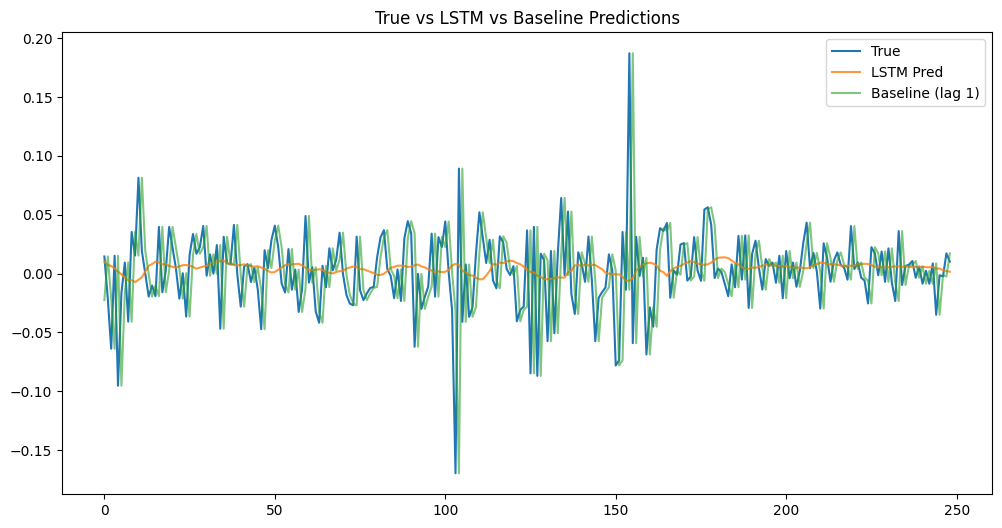

In [71]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm
import matplotlib.pyplot as plt

# =========================
# 1. Prepare Data
# =========================
# assume df has columns: ["date", "Return"]
df = merged.copy()
df = df.dropna(subset=["Return"])
returns = df["Return"].values.reshape(-1, 1)

# scale
scaler_y = MinMaxScaler()
returns_scaled = scaler_y.fit_transform(returns)

# build sequences
def create_sequences(data, window=10):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window = 10
X, y = create_sequences(returns_scaled, window)

# train/test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# =========================
# 2. Build & Train LSTM
# =========================
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(window,1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# =========================
# 3. Predictions
# =========================
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# =========================
# 4. Baseline (yesterday’s return)
# =========================
baseline_pred = df["Return"].shift(1).iloc[-len(y_test_inv):].values.reshape(-1,1)

# =========================
# 5. Metrics
# =========================
def eval_metrics(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    rmse = mean_squared_error(y_true, y_hat) ** 0.5
    r2 = r2_score(y_true, y_hat)
    return mae, rmse, r2

mae_lstm, rmse_lstm, r2_lstm = eval_metrics(y_test_inv, y_pred)
mae_base, rmse_base, r2_base = eval_metrics(y_test_inv, baseline_pred)

print("📊 LSTM Performance")
print(f"MAE:  {mae_lstm:.6f}")
print(f"RMSE: {rmse_lstm:.6f}")
print(f"R²:   {r2_lstm:.4f}\n")

print("📊 Baseline Performance")
print(f"MAE:  {mae_base:.6f}")
print(f"RMSE: {rmse_base:.6f}")
print(f"R²:   {r2_base:.4f}\n")

# =========================
# 6. Diebold–Mariano Test
# =========================
def diebold_mariano(y_true, y_pred_1, y_pred_2, h=1, alternative='two-sided'):
    e1 = y_true.flatten() - y_pred_1.flatten()
    e2 = y_true.flatten() - y_pred_2.flatten()
    d = (e1**2 - e2**2)
    mean_d = np.mean(d)
    n = len(d)
    var_d = np.var(d, ddof=1)
    dm_stat = mean_d / np.sqrt(var_d / n)
    
    if alternative == 'two-sided':
        p_value = 2 * norm.cdf(-abs(dm_stat))
    elif alternative == 'less':
        p_value = norm.cdf(dm_stat)
    else:  # 'greater'
        p_value = 1 - norm.cdf(dm_stat)
    
    return dm_stat, p_value

dm_stat, p_val = diebold_mariano(y_test_inv, baseline_pred, y_pred, h=1)

print("📊 Diebold-Mariano Test")
print(f"Statistic: {dm_stat:.4f}")
print(f"P-value:   {p_val:.4f}")
if p_val < 0.05:
    print("✅ LSTM significantly outperforms baseline.")
else:
    print("❌ No significant difference.")

# =========================
# 7. Plot
# =========================
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="True")
plt.plot(y_pred, label="LSTM Pred", alpha=0.8)
plt.plot(baseline_pred, label="Baseline (lag 1)", alpha=0.6)
plt.title("True vs LSTM vs Baseline Predictions")
plt.legend()
plt.show()
